# RNNs with toy-examples

In this notebook we go through a simple [toy example](https://www.cs.toronto.edu/~hinton/csc2535/notes/lec10new.pdf) of adding two binary numbers using RNNs:
<img src="images/adding_binary.png" width="600"/>
Why this is a good example for RNNs? This is because
* Firstly, adding two binary can be seeen as sequence input $x_t$ where
$$
x_t = \left(\begin{array}{c}
a_t\\
b_t
\end{array}\right)
$$
with $a_t, b_t$ is the $t-th$ bit of two input numbers.
* Secondly, as seen in above adding two binary numbers we need to store a carry bit (when adding two 1 or one 1 with carry bit 1). This carry-bit can be represented as memory from previous step.

Both above properties fit well with following RNNs structure:
<img src="images/vanilla_rnn_diagram.png" width="300"/>
where 
* $x_t$ is defined as above and can be one of the 4 following values
$$
\left(\begin{array}{c}0\\ 0 \end{array}\right), \left(\begin{array}{c}1\\ 0\end{array}\right),
\left(\begin{array}{c}0\\ 1\end{array}\right), \left(\begin{array}{c}1\\ 1\end{array}\right)
$$
* $h_t$ is hidden-cell and we use 3 neurons (rnn-size = 3) 
* $y_t$ is output which we use logistic to decide whether to output 0 or 1
* $z_t$ is target (the $t-th$ bit of the actual sum) which can be 0 or 1

Regarding the cost function, we can use cross-entropy
$$
-\left(z_t\log(y_t) + (1-z_t)\log(1-y_t)\right)
$$

Recall that the RNNs has following dynamics
$$
\begin{array}{rl}
h_t &= \tanh\left( x_{t} \times W_{xh} +  h_{t-1}\times W_{hh} + b_{hh}\right)\\
y_t &= \sigma(h_t \times W_{hy} + b_{hy})
\end{array}
$$
The goal is to find $W_{xh}, W_{hh}, W_{hy}, b_{hh}, b_{hy}$ so that our RNNs model produce the sum of two binary. In order to do so, we need to do the following steps
* Define training/testing dataset
* Ensemble our RNNs model
* Training RNNs and then do valuation on a test set

First we import the libraries we need and define the dataset.

In [142]:
import tensorflow as tf
import numpy as np
import time

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib notebook

# load 3d module
from mpl_toolkits.mplot3d import Axes3D

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Generate training/testing dataset
The following code block generate random integer and convert it to binary. Note that we need to remember that binary-representation in computer is right-to-left but our RNNs want input from left-to-right

In [124]:
def create_dataset(nb_samples, sequence_len):
    max_int = 2**(sequence_len - 1)
    bin_fmt = '{:0' + str(sequence_len) + 'b}'
    
    # input: array of (a_t, b_t) t-th binary of a & b
    dim_in = 2
    
    
    # input-samples has shape nb_samples, sequence_len, dim_in
    X = np.zeros([nb_samples, sequence_len, dim_in], dtype=np.float32)
    
    # target-samples has shape nb_Samples, sequence_len, dim_out
    T = np.zeros([nb_samples, sequence_len], dtype=np.int32)
    
    for i in range(nb_samples):
        nb1 = np.random.randint(0, max_int)
        nb2 = np.random.randint(0, max_int)
        
        X[i,:,0] = list(reversed([float(b) for b in bin_fmt.format(nb1)]))
        X[i,:,1] = list(reversed([float(b) for b in bin_fmt.format(nb2)]))
        
        T[i,:] = list(reversed([int(b) for b in bin_fmt.format(nb1 + nb2)]))
    return X,T

# create training sample
nb_train = 2000
seq_len  = 10
X_train, T_train = create_dataset(nb_train, seq_len)

print('X_train shape: {} of {}'.format(X_train.shape, X_train.dtype))
print('T_train shape: {} of {}'.format(T_train.shape, T_train.dtype))

X_train shape: (2000, 10, 2) of float32
T_train shape: (2000, 10) of int32


We create some helper function to create test inputs and visualisation

In [122]:
# create x, t given two number, we pad 0 to binary-inputs 
# so that inputs & target have same seq-len
def create_sum_test(nb1, nb2):
    fmt_bin = '{:b}'
    
    # convert to binary
    bin1    = fmt_bin.format(nb1)[::-1]
    bin2    = fmt_bin.format(nb2)[::-1]
    sum_bin = fmt_bin.format(nb1 + nb2)[::-1]
    
    # create input & target
    max_len = max(len(bin1), len(bin2)) + 1
    x = np.zeros([max_len, 2], dtype = np.float32)
    t = np.zeros(max_len, dtype = np.int32)
    x[0:len(bin1), 0] = [float(b) for b in bin1]
    x[0:len(bin2), 1] = [float(b) for b in bin2]
    t[0:len(sum_bin)] = [int(b) for b in sum_bin]
    return x, t

# convert a binary sequence to str for visualisation
# note that we need to reversed input before convert to str
def bin_seq_tostr(x):
    return ''.join(['{:d}'.format(int(b)) for b in reversed(x)])

# an example of using create_sum_test and bin_seq_tostr
nb1=47
nb2=123
x,t = create_sum_test(nb1, nb2)

print ('', bin_seq_tostr(x[:,0]))
print ('+')
print ('', bin_seq_tostr(x[:,1]))
print ('_'*(len(t)+2))
print ('', bin_seq_tostr(t))

 00101111
+
 01111011
__________
 10101010


# Ensemble a RNNs model
We will use Tensorflow to create a RNNs model via the help of the following functions
* [`tf.one_hot`](https://www.tensorflow.org/api_docs/python/tf/one_hot) to convert target into one-hot representation
* [`tf.contrib.rnn.BasicRNNCell`](https://www.tensorflow.org/api_docs/python/tf/contrib/rnn/BasicRNNCell) to model a basic RNN cell
* [`tf.nn.dynamic_rnn`](https://www.tensorflow.org/api_docs/python/tf/nn/dynamic_rnn) to perform fully dynamic unrolling of our rnn i.e we compute the final state of our RNN

In [123]:
# BinaryAddRnn builds a RNNs for the task of adding two binary number
class BinaryAddRnn(object):
    def __init__(self, inputs, targets, rnn_size = 3, learning_rate = 0.001):
        self._inputs_train  = inputs
        self._targets_train = targets
        
        assert(len(self._targets_train.shape)==2)
        assert(self._inputs_train.shape[:-1] == self._targets_train.shape)
        assert(self._inputs_train.shape[-1]==2)
        
        self._N, self._seq_len = self._targets_train.shape
        self._lr = learning_rate
        self._rnn_size = rnn_size        
        
        self.build_graph()
    
    def build_graph(self):
        self._graph = tf.Graph()
        
        self._create_placeholder()
        self._create_rnn()
        self._create_loss()
        self._create_train_op()
        
        # create saver to saved trained session
        with self._graph.as_default():
            self._saver = tf.train.Saver()
        
    def _create_placeholder(self):
        with self._graph.as_default():
            # create placehold for inputs & targets
            self._inputs  = tf.placeholder(tf.float32, [None, None, 2], name = 'inputs')
            self._targets = tf.placeholder(tf.int32,   [None, None],    name = 'targets')
        
            # convert target into one-hot for binary classifier and reshape it
            self._labels = tf.reshape(tf.one_hot(self._targets, 2), [-1, 2])
    
    def _create_rnn(self):
        with self._graph.as_default():
            with tf.variable_scope("rnn_scopes") as vs:
                # create rnn-cell            
                self._cell = tf.contrib.rnn.BasicRNNCell(self._rnn_size)

                # run rnn through inputs
                self._outputs, self._final_state = tf.nn.dynamic_rnn(self._cell,
                                                                     self._inputs, 
                                                                     dtype = tf.float32)

                # Retrieve just the LSTM variables.
                self._rnn_variables = [v for v in tf.global_variables() if v.name.startswith(vs.name)]
            
    def _create_loss(self):
        with self._graph.as_default():
            # create output weights & biases
            self._out_weights = tf.Variable(tf.truncated_normal([self._rnn_size,2], stddev=0.01), 
                                            name = 'out_weights')
            self._out_biases  = tf.Variable(tf.zeros([2]), name = 'out_biases')
            
            # note that self._outputs has shape [batch_size, seq_len, 3]
            # and we want to define
            #            y_t[i] = self._outputs[i, t, :] * self._out_weights + self._out_biases
            # so we need to reshape self._outputs to [-1, 3]
            
            _outputs_reshape = tf.reshape(self._outputs, [-1, self._rnn_size])
            
            # logits has shape [batch_size * seq_len, 2]
            self._logits = tf.matmul(_outputs_reshape, self._out_weights) + self._out_biases
            
            # prediction is argmax of logits 
            self._pred = tf.cast(tf.argmax(self._logits, axis=1), tf.int32)
            
            # we need flatten target
            targets_flat = tf.reshape(self._targets, [-1])
            correct_pred = tf.equal(self._pred, targets_flat)
            
            self._acc = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
            
            self._loss = tf.nn.sigmoid_cross_entropy_with_logits(labels = self._labels,
                                                                 logits = self._logits)
            self._cost = tf.reduce_mean(self._loss)
    
    def _create_train_op(self):
        with self._graph.as_default():
            # apply gradient clipping to control exploiding gradient
            tvars    = tf.trainable_variables()
            grads, _ = tf.clip_by_global_norm(tf.gradients(self._cost, tvars), 5.0)
            
            # create train-op with gradient clipping
            optimizer = tf.train.AdamOptimizer(learning_rate=self._lr)
            self._train_op = optimizer.apply_gradients(zip(grads, tvars))
    
    def _create_feed_dict(self, inputs, targets):
        return {self._inputs : inputs,
                self._targets: targets}
    
    def get_batches(self, batch_size):
        idx = np.arange(self._N)
        np.random.shuffle(idx)
        nb_batches = self._N // batch_size
        
        # create mini-batch and yield to save memory
        for i in range(nb_batches):
            batch_idx = idx[i * batch_size : (i + 1) * batch_size]
            yield self._inputs_train[batch_idx], self._targets_train[batch_idx]
            
    
    def train(self, epochs, batch_size, print_every = 100, save_path = 'checkpoints/add_bin_rnn.cpkt'):
        with tf.Session(graph=self._graph) as sess:
            # initilize all variable
            sess.run(tf.global_variables_initializer())

            iterations = 1
            nb_batches = self._N // batch_size

            # train via epoch
            for e in range(epochs):
                # run training with mini-batches
                i_batch = 1
                for inputs, targets in self.get_batches(batch_size):
                    start = time.time()
                    loss, acc, _ = sess.run([self._cost, self._acc, self._train_op], 
                                       feed_dict = self._create_feed_dict(inputs, targets))
                    end = time.time()
                    if (iterations % print_every == 0):
                        print("Epoch ({}/{})".format(e, epochs),
                                  "Batch ({:>3d}/{:<3d})".format(i_batch, nb_batches),
                                  "Iteration: {:>4d}".format(iterations),
                                  "Training loss: {:.4f}".format(loss),
                                  "accuracy: {:.4f}".format(acc),
                                  "running {:.4f} sec/batch".format((end - start)))

                    iterations += 1
                    i_batch    += 1

            # saved model down
            self._saver.save(sess, save_path)
            self._latest_check_point = save_path

            # return trained_weights
            trained_params = {'rnn_weights' : self._rnn_variables[0].eval(),
                              'rnn_biases'  : self._rnn_variables[1].eval(),
                              'out_weights' : self._out_weights.eval(),
                              'out_biases'  : self._out_biases.eval()}

            return trained_params
        
    def eval(self, nb1, nb2):
        x,t = create_sum_test(nb1, nb2)
        seq_len = x.shape[0]

        # reshape so that we put in feed_dict
        inputs  = x.reshape([1,seq_len, 2])
        targets = t.reshape([1,seq_len])
        with tf.Session(graph=self._graph) as sess:
            self._saver.restore(sess, self._latest_check_point)

            # run prediction
            pred = sess.run(self._pred, feed_dict = self._create_feed_dict(inputs, targets))

            # print to console
            print ('input  ', bin_seq_tostr(x[:,0]))
            print ('      +')
            print ('       ', bin_seq_tostr(x[:,1]))
            print ('       ','_'*(len(t)+1))
            print ('pred   ', bin_seq_tostr(pred))
            print ('target ', bin_seq_tostr(t))

We are ready to create our RNNs model

In [125]:
binAddRnn = BinaryAddRnn(X_train, T_train, learning_rate=0.02)            

# Training & Valuation
Let train 

In [129]:
epochs = 30
batch_size = 50
trained_params = binAddRnn.train(epochs, batch_size, print_every = 50)

Epoch (1/30) Batch ( 10/40 ) Iteration:   50 Training loss: 0.6729 accuracy: 0.6060 running 0.0042 sec/batch
Epoch (2/30) Batch ( 20/40 ) Iteration:  100 Training loss: 0.4709 accuracy: 0.6960 running 0.0039 sec/batch
Epoch (3/30) Batch ( 30/40 ) Iteration:  150 Training loss: 0.2009 accuracy: 1.0000 running 0.0039 sec/batch
Epoch (4/30) Batch ( 40/40 ) Iteration:  200 Training loss: 0.1042 accuracy: 1.0000 running 0.0038 sec/batch
Epoch (6/30) Batch ( 10/40 ) Iteration:  250 Training loss: 0.0666 accuracy: 1.0000 running 0.0037 sec/batch
Epoch (7/30) Batch ( 20/40 ) Iteration:  300 Training loss: 0.0464 accuracy: 1.0000 running 0.0036 sec/batch
Epoch (8/30) Batch ( 30/40 ) Iteration:  350 Training loss: 0.0355 accuracy: 1.0000 running 0.0036 sec/batch
Epoch (9/30) Batch ( 40/40 ) Iteration:  400 Training loss: 0.0277 accuracy: 1.0000 running 0.0037 sec/batch
Epoch (11/30) Batch ( 10/40 ) Iteration:  450 Training loss: 0.0213 accuracy: 1.0000 running 0.0036 sec/batch
Epoch (12/30) Batc

Let test with two number

In [130]:
nb1=np.random.randint(2**10)
nb2=np.random.randint(2**10)
binAddRnn.eval(nb1, nb2)

input   01000010101
      +
        01101101111
        ____________
pred    10110000100
target  10110000100


The model works well with longer sequence than the training input, now let's visualize the hidden state when we  

In [159]:
def color_trans(prev_out, prev_carry, x):
    sum_x = np.sum(x)    
    color_arrays = np.array([[['g', 'y', 'b'],
                              ['y', 'b', 'r']],
                             [['g', 'y', 'b'],
                              ['y', 'b', 'r']]])
    return color_arrays[prev_out, prev_carry, sum_x]

def colors_map(out, carry):
    colors_arrays = np.array([['g', 'b'],
                              ['y', 'r']])
    return colors_arrays[out, carry]

# choose a seq_len
seq_len = 5000

# generate random input
x       = np.random.randint(2, size=[seq_len, 2])
hiddens = np.zeros([seq_len, 3], np.float32)
carrys  = np.zeros([seq_len], np.int32)

First, let's display hidden state and color it using the state of (output, carry)
* (ouput=0, carry=0): green
* (ouput=0, carry=1): blue
* (ouput=1, carry=0): yellow
* (ouput=1, carry=1): red

nb prediction error/seq_len: 0/5000


<IPython.core.display.Javascript object>


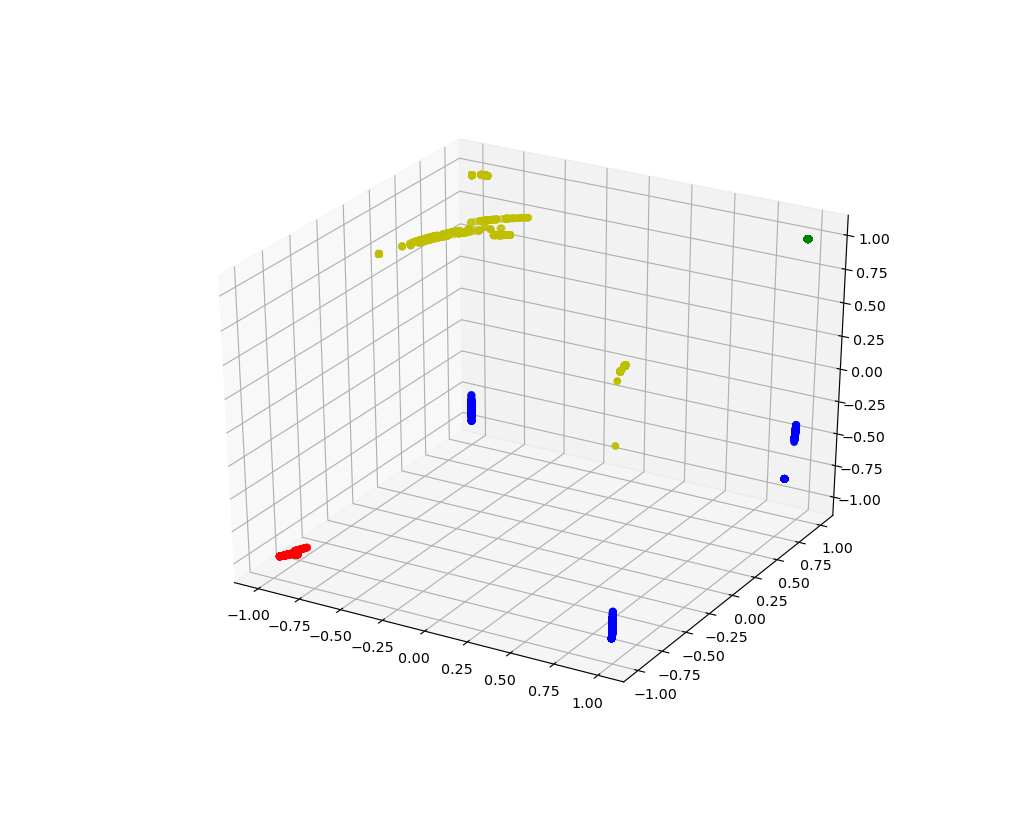

In [168]:
h       = np.zeros([3])
output  = 0
carry   = 0
colors  = []
nb_err  = 0
for i in range(seq_len):
    # compute hidden layer
    x_h = np.concatenate([x[i, :] , h], axis=0)
    h = np.tanh(x_h.dot(trained_params['rnn_weights']) + trained_params['rnn_biases'])    
    y = h.dot(trained_params['out_weights'] ) + trained_params['out_biases']
    pred = np.argmax(y)
    hiddens[i,:] = h[:]
        
    carry += int(np.sum(x[i,:])) 
    output = carry % 2
    carry = carry // 2    
    
    # color by (output, carry)    
    colors.append(colors_map(output, carry))
    
    # check if pred is correct
    nb_err += 1 if (pred != output) else 0        
    

print ('nb prediction error/seq_len: {}/{}'.format(nb_err, seq_len))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(hiddens[:,0], hiddens[:,1], hiddens[:,2], c = colors)
plt.show()

We can see hidden state is clustered by color, so the RNNs has learnt its current state. Now we check if it remember previous state by using transition-color as following

| prev_output   | prev_carry    | input       | color |
|:-------------:|:-------------:|:-----------:|:-----:|
|         0     |      0        | (0,0)       |  g    |
|         0     |      0        | (0,1)/(1,0) |  y    |
|         0     |      0        | (1,1)       |  b    |
|         0     |      1        | (0,0)       |  y    |
|         0     |      1        | (0,1)/(1,0) |  b    |
|         0     |      1        | (1,1)       |  r    |
|         1     |      0        | (0,0)       |  g    |
|         1     |      0        | (0,1)/(1,0) |  y    |
|         1     |      0        | (1,1)       |  b    |
|         1     |      1        | (0,0)       |  y    |
|         1     |      1        | (0,1)/(1,0) |  b    |
|         1     |      1        | (1,1)       |  r    |

where color decode state-transition (output, carry) given previous state (prev_output, prev_carry) known. Re-call the state-transition for binary addition is
<img src="images/add_bin_states.png" width="600"/>

<IPython.core.display.Javascript object>


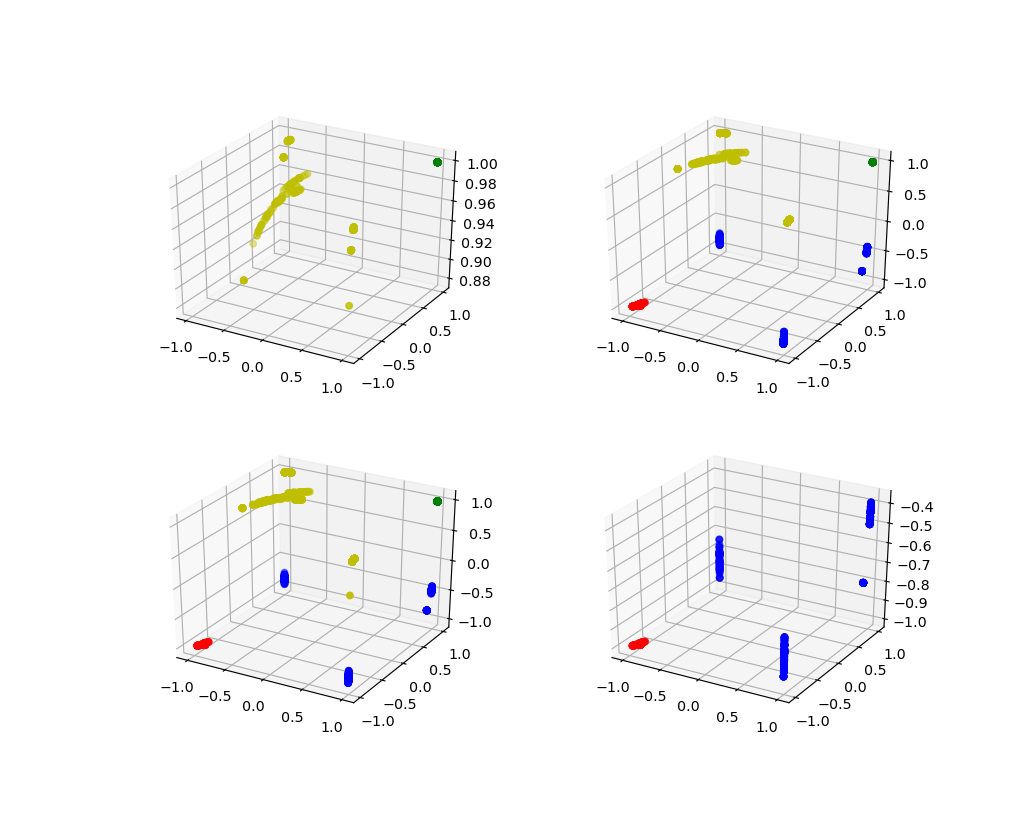

In [183]:
h       = np.zeros([3])
output  = 0
carry   = 0
nb_err  = 0
trans_colors = []
for i in range(seq_len):
    # color by transition   
    trans_colors.append(color_trans(output, carry, x[i, :]))
    
    # update carry & output
    carry += int(np.sum(x[i,:])) 
    output = carry % 2
    carry  = carry // 2    
    
colors = np.array(colors)
trans_colors = np.array(trans_colors)

fig = plt.figure()
# we want to know previous color of hidden state
sp = [221, 222,223,224]
for c,sp in zip(['g', 'b', 'y', 'r'], sp):
    idx, = np.where(colors == c)
    prev_idx = [i-1 for i in idx if i > 0]
   
    ax = fig.add_subplot(sp, projection='3d')
    ax.scatter(hiddens[prev_idx,0], hiddens[prev_idx,1], hiddens[prev_idx,2], c = trans_colors[prev_idx])
plt.show()

Looking at above result, it seems that RNNs has learnt the state-transition as well.

# Conclusion
Go through this toy examples we have seen the effectiveness of RNNs and it's quite easy to implemented with Tensorflows. 

Go though this we also learnt the following
* RNNs is known with exploiding gradient and the longer seq_len, the more severe the issue. When we don't use clipping gradient, the training sometimes works sometimes not.
* RNNs seems working well for longer sequence (beyond what we train) which is quite magical
* How to visualize RNNs' hidden state